### Basic cell for imports etc

In [11]:
import numpy as np
import pandas as pd
from healpy.sphtfunc import smoothing
import smica
import os
import json
import component_separation
import component_separation.io as io
import healpy as hp
import component_separation.MSC.MSC.pospace as ps
import component_separation.powspec as pw
import component_separation.preprocess as prep
from component_separation.cs_util import Config as csu
from component_separation.cs_util import Constants as const
from component_separation.cs_util import Helperfunctions as hpf
from component_separation.cs_util import Planckf, Planckr, Plancks
import matplotlib.pyplot as plt
with open(os.path.dirname(component_separation.__file__)+'/config.json', "r") as f:
    cf = json.load(f)
    
import platform
uname = platform.uname()
if uname.node == "DESKTOP-KMIGUPV":
    mch = "XPS"
else:
    mch = "NERSC"
bins = const.linear_equisized_bins_10
signal = pd.read_csv(
        cf[mch]['powspec_truthfile'],
        header=0,
        sep='    ',
        index_col=0)
spectrum_trth = signal["Planck-"+"EE"].to_numpy()

def bin_it(data, bins, offset=0):
    ret = np.ones(len(bins))
    for k in range(bins.shape[0]):
        ret[k] = np.mean(np.nan_to_num(data[int(bins[k][0]):int(bins[k][1])]))
    return np.nan_to_num(ret)

<ipython-input-11-ecb00f51179f>:28: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  signal = pd.read_csv(


### Load data and bin it, when applicable

In [12]:
lmax = cf['pa']["lmax"]
lmax_mask = cf['pa']["lmax_mask"]
freqfilter = cf['pa']["freqfilter"]
specfilter = cf['pa']["specfilter"]
offset=0
C_ltot = io.load_data(path_name=io.spec_sc_path_name)
cov_ltot = pw.build_covmatrices(C_ltot, lmax=lmax, freqfilter=freqfilter, specfilter=specfilter)["EE"]
    
def postprocess_spectrum(data, freqcomb, smoothing_window, max_polynom):
    if smoothing_window > 0 or max_polynom > 0:
        spec_sc = pw.smoothC_l(data, smoothing_window=smoothing_window, max_polynom=max_polynom)
    spec_sc = pw.apply_scale(data, scale=cf['pa']["Spectrum_scale"])
    beamf = io.load_beamf(freqcomb=freqcomb)
    spec_scbf = pw.apply_beamfunction(spec_sc, beamf, lmax, specfilter)
    return spec_scbf

C_lN_unsc = io.load_data(io.noise_unsc_path_name)
C_lN = postprocess_spectrum(C_lN_unsc, csu.freqcomb, cf['pa']['smoothing_window'], cf['pa']['max_polynom'])
cov_lN = pw.build_covmatrices(C_lN, lmax=lmax, freqfilter=freqfilter, specfilter=specfilter)

cov_ltot_bnd = hpf.bin_it(cov_ltot, bins=bins, offset=offset)
cov_lN_bnd = np.diagonal(hpf.bin_it(cov_lN["EE"], bins=bins, offset=offset), offset=offset, axis1=0, axis2=1).T

signal = pd.read_csv(
    cf[mch]['powspec_truthfile'],
    header=0,
    sep='    ',
    index_col=0)
freqdset = cf['pa']['freqdset']
spectrum_trth = signal["Planck-"+"EE"].to_numpy()
C_lS_bnd =  hpf.bin_it(np.ones((7,7,lmax+1))* spectrum_trth[:lmax+1]/hpf.llp1e12(np.array([range(lmax+1)])), bins=bins, offset=offset)*1e12
smica_spec = io.load_data(io.out_specsmica_path + freqdset + cf[mch][freqdset]['sim_id'] + io.specsmica_sc_filename
    )[0,0,:]

cmb_in = io.load_data("/global/cscratch1/sd/sebibel/spectrum/NPIPE_sim_cmb/SPEC0200_C_l_NPIPE_sim_cmb_lens_3000_6000_0_0_Full.npy")

tf = io.load_data(cf[mch]['outdir_misc_ap']+"tf0200.npy")

loaded /global/cscratch1/sd/sebibel/spectrum/NPIPE_sim/SPEC0200_C_l_NPIPE_sim_lens_3000_6000_0_0_Full.npy
loaded /global/cscratch1/sd/sebibel/spectrum/NPIPE_sim_diff/SPEC-RAW_0200_C_l_NPIPE_sim_diff_lens_3000_6000_Full.npy


<ipython-input-12-666ab495ae7c>:24: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  signal = pd.read_csv(
<ipython-input-12-666ab495ae7c>:31: RuntimeWarning: invalid value encountered in true_divide
  C_lS_bnd =  hpf.bin_it(np.ones((7,7,lmax+1))* spectrum_trth[:lmax+1]/hpf.llp1e12(np.array([range(lmax+1)])), bins=bins, offset=offset)*1e12


loaded /global/cscratch1/sd/sebibel/spectrum/NPIPE_sim/NPIPE_sim0200SPECSMICA0200_C_l_NPIPE_sim_lens_3000_6000_0_0_Full.npy
loaded /global/cscratch1/sd/sebibel/spectrum/NPIPE_sim_cmb/SPEC0200_C_l_NPIPE_sim_cmb_lens_3000_6000_0_0_Full.npy
loaded /global/cscratch1/sd/sebibel/misc/tf0200.npy


### Plot empiric data and noise

In [13]:
for n in range(3,7):
    plt.plot(np.mean(bins,axis=1), cov_ltot_bnd[n,n,:],alpha=0.8)
    plt.plot(cov_ltot[n,n,:],alpha=0.3, color='black',lw=4)
plt.xlim((100,3000))
plt.ylim((1e-4,1e1))
plt.yscale('log')

### in addition, plot smica cmb result, noise-only, and planck best-EE estimate

In [18]:
%matplotlib widget
plt.plot(np.mean(bins,axis=1), C_lS_bnd[1,1,:])
# plt.plot(spectrum_trth[:lmax+1]/hpf.llp1e12(np.array(range(lmax+1)))*1e12)
for n in range(3,7):
    plt.plot(np.mean(bins,axis=1), cov_lN_bnd[n])
    plt.plot(cov_ltot[n,n,:],alpha=0.3)
    
plt.plot(np.mean(bins,axis=1), smica_spec, label = 'smica spec')
plt.legend()
# plt.plot(np.mean(bins,axis=1), cmb_in)
plt.xlim((100,3000))
plt.ylim((1e-7,1e1))
plt.yscale('log')
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [15]:
# cmb_spec_in_bnd = io.load_data(cf[mch]['outdir_misc_ap']+"cmb_in0200.npy")
# plt.plot(np.mean(bins,axis=1), cmb_spec_in_bnd, label='mv cmb in')
# plt.plot(np.mean(bins,axis=1), C_lS_bnd[1,1,:], label='best estimate planck ee')
# plt.plot(cmb_in['143-143']['EE'], label='cmb ee in 143ghz')
plt.plot(np.mean(bins,axis=1), (bin_it(cmb_in['143-143']['EE'], bins=bins)-C_lS_bnd[1,1,:])/C_lS_bnd[1,1,:],label= 'cmb in')#/bin_it(hp.sphtfunc.pixwin(2048, pol=True, lmax=3000)[0], bins=bins))#*bin_it(hp.gauss_beam(0.00145444,lmax=lmax),bins=bins,))
plt.plot(np.mean(bins,axis=1), (smica_spec-C_lS_bnd[1,1,:])/C_lS_bnd[1,1,:], label='cmb out')
plt.xlim((100,3000))
plt.ylim((-0.1,0.2))
plt.legend()
plt.ylabel('Rel. difference')
plt.xlabel('Multipole')
# plt.yscale('log')

<ipython-input-15-5566afb22b8e>:8: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim((-0.1,0.2))


Text(0.5, 23.52222222222222, 'Multipole')

### The following plot is the E2E transferfunction using smica
    * it uses a single detector as cmb_in. 
    * in addition, smica was only fed the HFI


In [17]:
%matplotlib widget
plt.plot(np.mean(bins,axis=1), np.sqrt(bin_it(cmb_in['143-143']['EE'], bins=bins)/smica_spec))#/bin_it(hp.sphtfunc.pixwin(2048, pol=True, lmax=3000)[0], bins=bins))#*bin_it(hp.gauss_beam(0.00145444,lmax=lmax),bins=bins,))
pixwin = hp.sphtfunc.pixwin(2048, pol=True, lmax=1800)
plt.xlim((100,3000))
plt.ylim((0.95,1.05))
plt.hlines(1,100,3000, color='black', ls = "--")
plt.title('E2E transferfunction')
plt.xlabel('Multipole')
plt.ylabel(r"$\sqrt{\frac{CMB_{in}}{CMB_{out}}}}$", fontsize=16)#\frac{1}{Pixw}
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [12]:
np.cov(bin_it(cmb_in['143-143']['EE'], bins=bins), smica_spec)#/bin_it(hp.sphtfunc.pixwin(2048, pol=True, lmax=3000)[0], bins=bins))#*bin_it(hp.gauss_beam(0.00145444,lmax=lmax),bins=bins,))

array([[4.25104059e-08, 4.18810961e-08],
       [4.18810961e-08, 4.12864619e-08]])

### BACKUP

(285,)


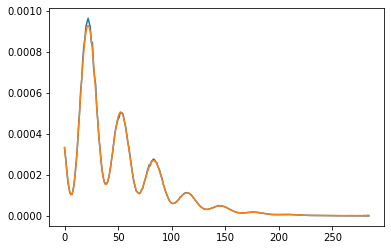

In [20]:
plt.plot(bin_it(cmb_in['143-143']['EE'], bins=bins))
plt.plot(smica_spec)
print(smica_spec.shape)

In [31]:
cmb_in_alm = hp.synalm(bin_it(cmb_in['143-143']['EE'], bins=bins))
smica_alm = hp.synalm(smica_spec)
# smica_alm = hp.synalm(np.random.random(size=285))*0.012
crsspec1 = hp.alm2cl(cmb_in_alm, alms2=smica_alm)
crsspec2 = hp.alm2cl(cmb_in_alm, alms2=cmb_in_alm)
crsspec3 = hp.alm2cl(smica_alm, alms2=smica_alm)

/global/homes/s/sebibel/.local/cori/3.8-anaconda-2020.11/lib/python3.8/site-packages/healpy-1.14.0-py3.8-linux-x86_64.egg/healpy/sphtfunc.py:433: FutureChangeWarning: The order of the input cl's will change in a future release.
Use new=True keyword to start using the new order.
See documentation of healpy.synalm.
  warnings.warn(


(285,)


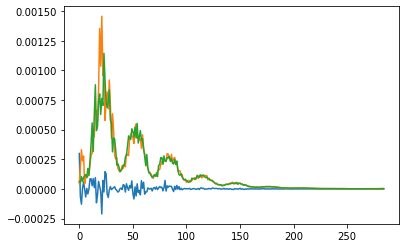

In [32]:
print(crsspec.shape)
plt.plot(crsspec)
plt.plot(crsspec2)
plt.plot(crsspec3)

In [12]:
tf = io.load_data(cf[mch]['outdir_misc_ap']+"tf0200.npy")
pixwin = hp.sphtfunc.pixwin(2048, pol=True, lmax=1800)
# cmb_in = io.load_data(cf[mch]['outdir_misc_ap']+"cmb_spec_in.npy")
smica_spec = io.load_data(io.out_specsmica_path + freqdset + cf[mch][freqdset]['sim_id'] + io.specsmica_sc_filename
    )[0,0,:]
C_lN = io.load_data(io.noise_sc_path_name)
C_lS_bn =  spectrum_trth[:4000+1]/hpf.llp1e12(np.arange(0,4001,1))*1e12


loaded /global/cscratch1/sd/sebibel/misc/tf0200.npy
no existing data at /global/cscratch1/sd/sebibel/spectrum/NPIPE_sim/NPIPE_sim_cmb0200SPECSMICA0200_C_l_NPIPE_sim_lens_3000_6000_0_0_Full.npy


TypeError: 'NoneType' object is not subscriptable

NameError: name 'smica_spec' is not defined

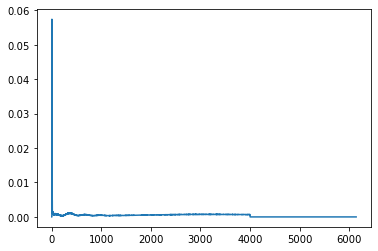

In [9]:
plt.plot(cmb_in[1,:]*1e12, label='cmb in')
plt.plot(np.mean(bins,axis=1), smica_spec, label='smica out')
plt.plot(C_lS_bn, label = 'cls bnd')
# plt.plot(pixwin[1][::100])
plt.xlim((1e1,4e3))
plt.legend()
plt.ylim((1e-6,1e-1))
plt.xscale('log')
plt.yscale('log')

In [3]:
smica_spec = io.load_data(io.spec_sc_path_name+'SMICA.npy')[0,0,:]
cmb_spec_in = io.load_data(cf[mch]['outdir_misc_ap']+"cmb_spec_in.npy")
print(smica_spec.shape)
print(cmb_spec_in.shape)
plt.plot(np.mean(bins,axis=1), smica_spec)
plt.plot(cmb_spec_in[1,:]*1e12)
plt.xlim((100,1800))
plt.ylim((1e-7,1e-2))

no existing data at /global/cscratch1/sd/sebibel/spectrum/NPIPE_sim/SPEC0200_NPIPE_sim_lens_3000_6000_030,044,070,100,143,217,353_TT,EE,BB,TE_0_0_Full.npySMICA.npy


TypeError: 'NoneType' object is not subscriptable

(0.0, 0.001)

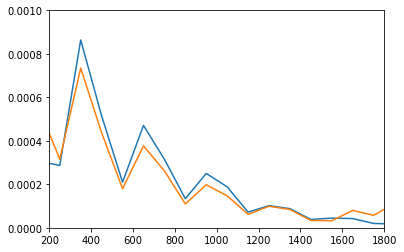

In [32]:
plt.plot(np.mean(bins,axis=1), bin_it(C_lS_bn, bins=bins))
plt.plot(np.mean(bins,axis=1), smica_spec)
plt.xlim((200,1800))
plt.ylim((0,0.001))

In [3]:
cmb_map_in = hp.read_map("/global/cfs/cdirs/cmb/data/planck2018/pr3/cmbmaps/dx12_v3_smica_cmb_raw.fits", field=(0,1,2))
cmb_spec_in = hp.anafast(cmb_map_in)

/global/homes/s/sebibel/.local/cori/3.8-anaconda-2020.11/lib/python3.8/site-packages/healpy-1.14.0-py3.8-linux-x86_64.egg/healpy/fitsfunc.py:368: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(
/global/homes/s/sebibel/.local/cori/3.8-anaconda-2020.11/lib/python3.8/site-packages/healpy-1.14.0-py3.8-linux-x86_64.egg/healpy/fitsfunc.py:391: UserWarning: NSIDE = 2048
  warnings.warn("NSIDE = {0:d}".format(nside))
/global/homes/s/sebibel/.local/cori/3.8-anaconda-2020.11/lib/python3.8/site-packages/healpy-1.14.0-py3.8-linux-x86_64.egg/healpy/fitsfunc.py:400: UserWarning: ORDERING = RING in fits file
  warnings.warn("ORDERING = {0:s} in fits file".format(ordering))
/global/homes/s/sebibel/.local/cori/3.8-anaconda-2020.11/lib/python3.8/site-packages/he

loaded /global/cscratch1/sd/sebibel/spectrum/NPIPE_sim/SPEC0200_NPIPE_sim_lens_3000_6000_5_2_030,044,070,100,143,217,353_TT,EE,BB,TE_Full.npySMICA.npy


In [ ]:
def bin_it(data, bins, offset=0):
    ret = np.ones(len(bins))
    for k in range(bins.shape[0]):
        ret[k] = np.mean(np.nan_to_num(data[int(bins[k][0]):int(bins[k][1])]))
    return np.nan_to_num(ret)

plt.plot(cmb_spec_in[1,:], label='planck cmb in')
plt.plot(np.mean(bins,axis=1), smica_spec*1e-12, label='smica out')
plt.plot(spectrum_trth)
plt.legend()
plt.ylim((1e-17,1e-14))
plt.yscale("log")

In [34]:
from astropy.io import fits
hdul = fits.open("/global/cfs/cdirs/cmb/data/planck2018/pr3/cmbmaps/dx12_v3_smica_cmb_raw.fits")

In [38]:
print(hdul[1].data.field(1).shape)
hdul[1].header
i = hdul[1].data.field(0).reshape(-1)
q = hdul[1].data.field(1).reshape(-1)
u = hdul[1].data.field(2).reshape(-1)

(49152, 1024)


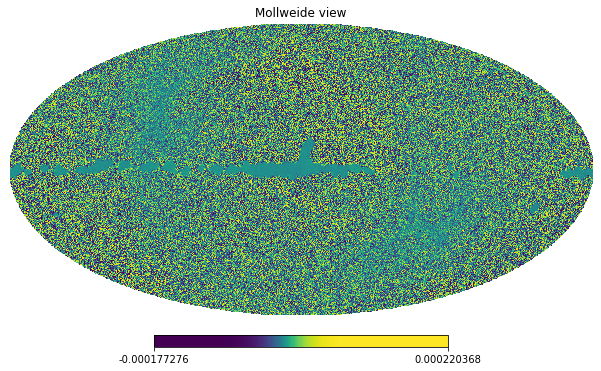

In [44]:
hp.mollview(q,norm='hist')

In [45]:
cmb_spec_in = hp.anafast([i,q,u])

In [46]:
print(cmb_spec_in.shape)
plt.plot(np.mean(bins,axis=1), tf*1e-6/(hp.sphtfunc.gauss_beam(0.00145444, lmax=1800, pol=True)[1,::100]/pixwin[1][::100]))
plt.show()

(6, 6144)


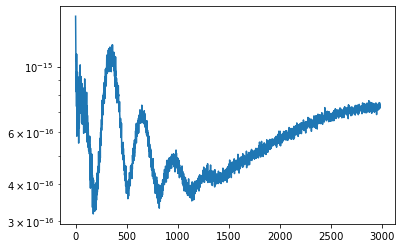

In [51]:
plt.plot(cmb_spec_in[1][20:3000])
plt.yscale("log")

In [53]:
syndata = io.load_data("/global/cscratch1/sd/sebibel/spectrum/NPIPE_sim/SPECSYN0200_NPIPE_sim_lens_3000_6000_5_2_030,044,070,100,143,217,353_TT,EE,BB,TE_Full.npy_5mean.npy")

loaded /global/cscratch1/sd/sebibel/spectrum/NPIPE_sim/SPECSYN0200_NPIPE_sim_lens_3000_6000_5_2_030,044,070,100,143,217,353_TT,EE,BB,TE_Full.npy_5mean.npy


<ipython-input-85-943e59c0ff15>:3: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(indata[freqc]['EE']/syndata[freqc]['EE'], label=freqc, alpha=0.5)
<ipython-input-85-943e59c0ff15>:3: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(indata[freqc]['EE']/syndata[freqc]['EE'], label=freqc, alpha=0.5)
<ipython-input-85-943e59c0ff15>:3: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(indata[freqc]['EE']/syndata[freqc]['EE'], label=freqc, alpha=0.5)


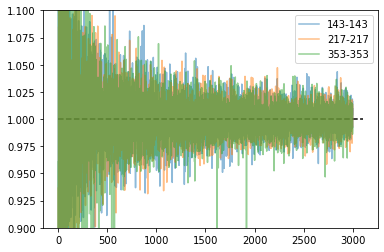

In [85]:
for freqc in csu.freqcomb:
    if freqc.split('-')[0] == freqc.split('-')[1] and freqc.split('-')[0]>str(100):
        plt.plot(indata[freqc]['EE']/syndata[freqc]['EE'], label=freqc, alpha=0.5)
#         plt.plot(syndata[freqc]['EE'], label=freqc)
plt.legend()
plt.ylim((0.9,1.1))
plt.hlines(1,0,3100,color="black", ls='--')
# plt.yscale('log')

In [62]:
indata = io.load_data("/global/cscratch1/sd/sebibel/spectrum/NPIPE_sim/SPEC0200_NPIPE_sim_lens_3000_6000_5_2_030,044,070,100,143,217,353_TT,EE,BB,TE_Full.npy")

loaded /global/cscratch1/sd/sebibel/spectrum/NPIPE_sim/SPEC0200_NPIPE_sim_lens_3000_6000_5_2_030,044,070,100,143,217,353_TT,EE,BB,TE_Full.npy


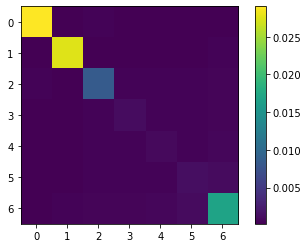

In [83]:
plt.imshow(cov_ltot_bnd[:,:,4])
plt.colorbar()

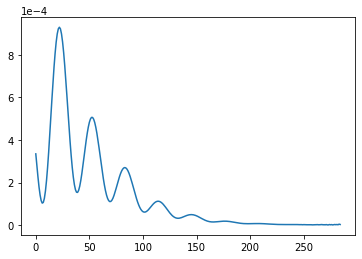

In [17]:
plt.plot(smica_spec)

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                12288 / length of dimension 1                          
NAXIS2  =                49152 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    3 / number of table fields                         
TTYPE1  = 'TEMPERATURE'                                                         
TFORM1  = '1024E   '                                                            
TTYPE2  = 'Q_POLARISATION'                                                      
TFORM2  = '1024E   '                                                            
TTYPE3  = 'U_POLARISATION'  

[[-8.2018460e-07  3.7217808e-07 -6.1451306e-07 ... -1.7658085e-06
  -1.2957443e-06 -1.5743608e-06]
 [ 2.7821575e-06  1.3509386e-06  4.5757233e-06 ...  2.9650749e-07
  -1.1538866e-06  4.0217901e-07]
 [-8.3540408e-07 -1.5467959e-06 -5.4301211e-08 ...  9.8310807e-07
   1.7478132e-07  1.4954783e-06]
 ...
 [ 1.0245515e-06  3.0434360e-06  1.5757887e-06 ... -2.9185128e-06
  -3.1594377e-06 -8.9632528e-07]
 [ 2.0853731e-06  1.9829654e-06  5.8004105e-07 ...  1.7229263e-06
   3.4289670e-07  2.9580883e-06]
 [-2.9794955e-06 -2.6842752e-06 -7.6854741e-07 ... -1.6159137e-06
  -2.4136455e-08  1.0523175e-06]]


/global/homes/s/sebibel/.local/cori/3.8-anaconda-2020.11/lib/python3.8/site-packages/healpy-1.14.0-py3.8-linux-x86_64.egg/healpy/pixelfunc.py:1581: UserWarning: monopole: 1.56359e-14  dipole: lon: 125.572, lat: -89.7208, amp: 2.51984e-14
  warnings.warn(


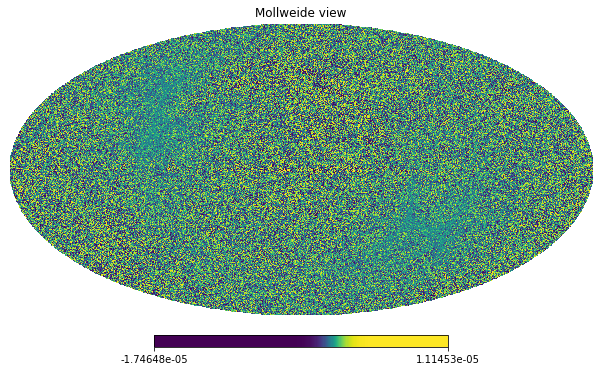

In [2]:
freqdset = cf['pa']['freqdset']+"_cmb"
tf = io.load_data(cf[mch]['outdir_misc_ap']+"tf{}.npy".format(cf[mch][freqdset]['sim_id']))

loaded /global/cscratch1/sd/sebibel/misc/tf0200.npy


In [34]:
import class_public

ModuleNotFoundError: No module named 'class_public'

In [2]:
from classy import Class

# Define your cosmology (what is not specified will be set to CLASS default parameters)
params = {
    'output': 'tCl lCl',
    'l_max_scalars': 2000,
    'lensing': 'yes',
    'A_s': 2.3e-9,
    'n_s': 0.9624, 
    'h': 0.6711,
    'omega_b': 0.022068,
    'omega_cdm': 0.12029}

# Create an instance of the CLASS wrapper
cosmo = Class()

# Set the parameters to the cosmological code
cosmo.set(params)

# Run the whole code. Depending on your output, it will call the
# CLASS modules more or less fast. For instance, without any
# output asked, CLASS will only compute background quantities,
# thus running almost instantaneously.
# This is equivalent to the beginning of the `main` routine of CLASS,
# with all the struct_init() methods called.
cosmo.compute()

# Access the lensed cl until l=2000
cls = cosmo.lensed_cl(2000)

# Print on screen to see the output
print(cls)
# It is a dictionnary that contains the fields: tt, te, ee, bb, pp, tp

# plot something with matplotlib...

# Clean CLASS (the equivalent of the struct_free() in the `main`
# of CLASS. This step is primordial when running in a loop over different
# cosmologies, as you will saturate your memory very fast if you ommit
# it.
cosmo.struct_cleanup()

# If you want to change completely the cosmology, you should also
# clean the arguments, otherwise, if you are simply running on a loop
# of different values for the same parameters, this step is not needed
cosmo.empty()

{'tt': array([0.00000000e+00, 0.00000000e+00, 1.59618718e-10, ...,
       5.31700294e-17, 5.31165310e-17, 5.30628950e-17]), 'pp': array([0.00000000e+00, 0.00000000e+00, 9.61598918e-09, ...,
       5.30996036e-22, 5.29238969e-22, 5.27488305e-22]), 'tp': array([0.00000000e+00, 0.00000000e+00, 5.15684614e-10, ...,
       1.80911439e-22, 1.80680691e-22, 1.80440475e-22]), 'ell': array([   0,    1,    2, ..., 1998, 1999, 2000])}


dict_keys(['tt', 'pp', 'tp', 'ell'])


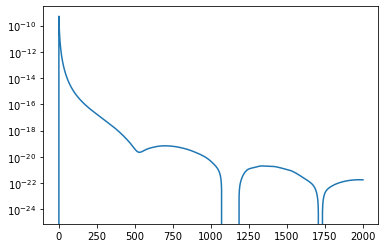

In [10]:
print(cls.keys())
plt.plot(cls['tp'])
plt.yscale('log')